# AXIS Stock Market based on different type of investors

This part of the assignment is based on the following:
######
    1. The investment can be long term or short term. The agent has to be able to find the difference between the investment and the time period. We will see how the agent performs in both the long and short cases. 
    2. For experimental purposes, the agent will be trained on A2C model and the difference would be evaluated between the investment and the time period.

In [171]:
# Gym stuff
import gym

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [172]:
df=pd.read_csv('./data_axis/batch (0).csv')
df=pd.DataFrame(data=df,columns=['Open','High','Low','Close','Volume'])
print("Data Types\n",df.dtypes)
print("\nShape of the dataset",df.shape)

Data Types
 Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

Shape of the dataset (529, 5)


In [173]:
df=pd.DataFrame(data=df,columns=['Open','High','Low','Close','Volume'])
df.head()

,Open,High,Low,Close,Volume
0,26.7,26.70,26.70,26.70,112100
1,27.0,28.70,26.50,26.85,234500
2,26.0,27.75,25.50,26.30,170100
3,25.8,27.00,25.80,25.95,102100
4,25.0,26.00,24.25,24.80,62600


In [174]:
from time import time
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym

# Discrete set of 2 actions, buying and selling.
class Actions(Enum):
    Sell = 0
    Buy = 1

# Shorting stock: Profiting from a stock's decline by selling borrowed shares, aiming to buy them back at a lower price.
# Longing stock: Profiting from a stock's rise by buying and holding shares, with the expectation of selling them at a higher price.

class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

# creating custom environment
class TradingEnv(gym.Env):

    metadata = {'render_modes': ['human'], 'render_fps': 3}

    def __init__(self, df, window_size, render_mode=None):
        assert df.ndim == 2
        assert render_mode is None or render_mode in self.metadata['render_modes']

        self.render_mode = render_mode

        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = gym.spaces.Discrete(len(Actions))
        INF = 1e10
        self.observation_space = gym.spaces.Box(
            low=-INF, high=INF, shape=self.shape, dtype=np.float32,
        )

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._truncated = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        self.action_space.seed(int((self.np_random.uniform(0, seed if seed is not None else 1))))

        self._truncated = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Short
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self._first_rendering = True
        self.history = {}

        observation = self._get_observation()
        info = self._get_info()

        if self.render_mode == 'human':
            self._render_frame()

        return observation, info

    def step(self, action):
        self._truncated = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._truncated = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade:
            self._position = self._position.opposite()
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = self._get_info()
        self._update_history(info)

        if self.render_mode == 'human':
            self._render_frame()

        return observation, step_reward, False, self._truncated, info

    def _get_info(self):
        return dict(
            total_reward=self._total_reward,
            total_profit=self._total_profit,
            position=self._position
        )

    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    def _render_frame(self):
        self.render()

    def render(self, mode='human'):
        # Red shows shorting of stock and Green shows Longing of the stock.
        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        start_time = time()

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("Total Reward: %.6f" % self._total_reward)
        print("Total Profit: %.6f" % self._total_profit)

        end_time = time()
        process_time = end_time - start_time

        pause_time = (1 / self.metadata['render_fps']) - process_time
        assert pause_time > 0., "High FPS! Try to reduce the 'render_fps' value."

        plt.pause(pause_time)

    def render_all(self, title=None):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        if title:
            plt.title(title)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

    def close(self):
        plt.close()

    def save_rendering(self, filepath):
        plt.savefig(filepath)

    def pause_rendering(self):
        plt.show()

    def _process_data(self):
        raise NotImplementedError

    def _calculate_reward(self, action):
        raise NotImplementedError

    def _update_profit(self, action):
        raise NotImplementedError

    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError

In [175]:
import numpy as np
# Customizing the environment. 
class StocksEnv(TradingEnv):

    def __init__(self, df, window_size, frame_bound, render_mode=None):
        assert len(frame_bound) == 2

        self.frame_bound = frame_bound
        super().__init__(df, window_size, render_mode)

        self.trade_fee_bid_percent = 0.01  # unit
        self.trade_fee_ask_percent = 0.005  # unit

    def _process_data(self):
        prices = self.df.loc[:, 'Close'].to_numpy()

        prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff))

        return prices.astype(np.float32), signal_features.astype(np.float32)
    
    # Reward function where we buy if shoring and sell when longing. 
    def _calculate_reward(self, action):
        step_reward = 0

        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price

            if self._position == Positions.Long:
                step_reward += price_diff

        return step_reward

    def _update_profit(self, action):
        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade or self._truncated:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self._position == Positions.Long:
                shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price
                self._total_profit = (shares * (1 - self.trade_fee_bid_percent)) * current_price

    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            if position == Positions.Long:
                current_price = self.prices[current_tick - 1]
                last_trade_price = self.prices[last_trade_tick]
                shares = profit / last_trade_price
                profit = shares * current_price
            last_trade_tick = current_tick - 1

        return profit

In [176]:
import gymnasium as gym

In [177]:
env = StocksEnv(df=df,window_size=5,frame_bound=(5,530))

In [178]:
print("Environment information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

Environment information:
> shape: (5, 2)
> df.shape: (529, 5)
> prices.shape: (529,)
> signal_features.shape: (529, 2)
> max_possible_profit: 748.1048310375149


In [179]:
# Showing progress in the graph showing total reward and total profit
def showProgress():
    plt.figure(figsize=(15,6))
    plt.cla()
    env.render_all()
    plt.show()

# Basic training of the model using A2C algorithm

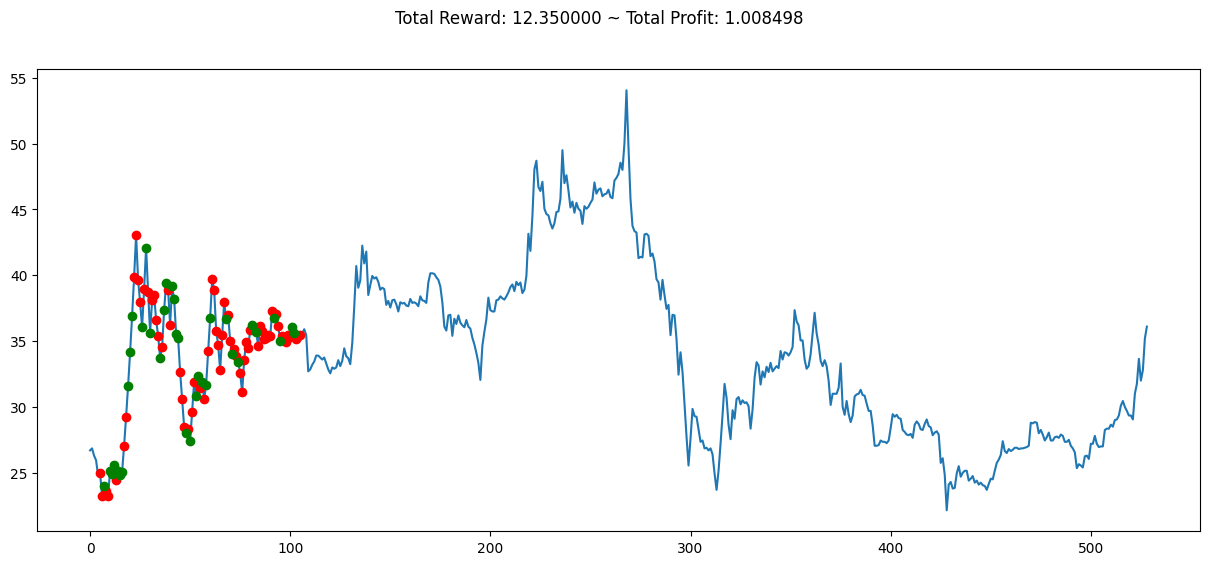

Learning finished...


In [180]:
from stable_baselines3 import A2C

a2cModel =  A2C("MlpPolicy", env)
a2cModel.learn(total_timesteps=100)
showProgress()
print("Learning finished...")

Importing Policies from Stable Baselines3

In [181]:
from stable_baselines3 import A2C

# Batching the input data
Training the model on each of the training datasets and making sure the training is done on top of the already trained model. This ensures that the previous data is not lost and the factor of the previous data is considered in the model. 

(529, 5)
Learning finished for batch (0)
(531, 5)
Learning finished for batch (1)
(530, 5)
Learning finished for batch (2)
(530, 5)
Learning finished for batch (3)
(530, 5)
Learning finished for batch (4)
(530, 5)
Learning finished for batch (5)
(530, 5)
Learning finished for batch (6)
(530, 5)
Learning finished for batch (7)
(530, 5)
Learning finished for batch (8)
(530, 5)
Learning finished for batch (9)


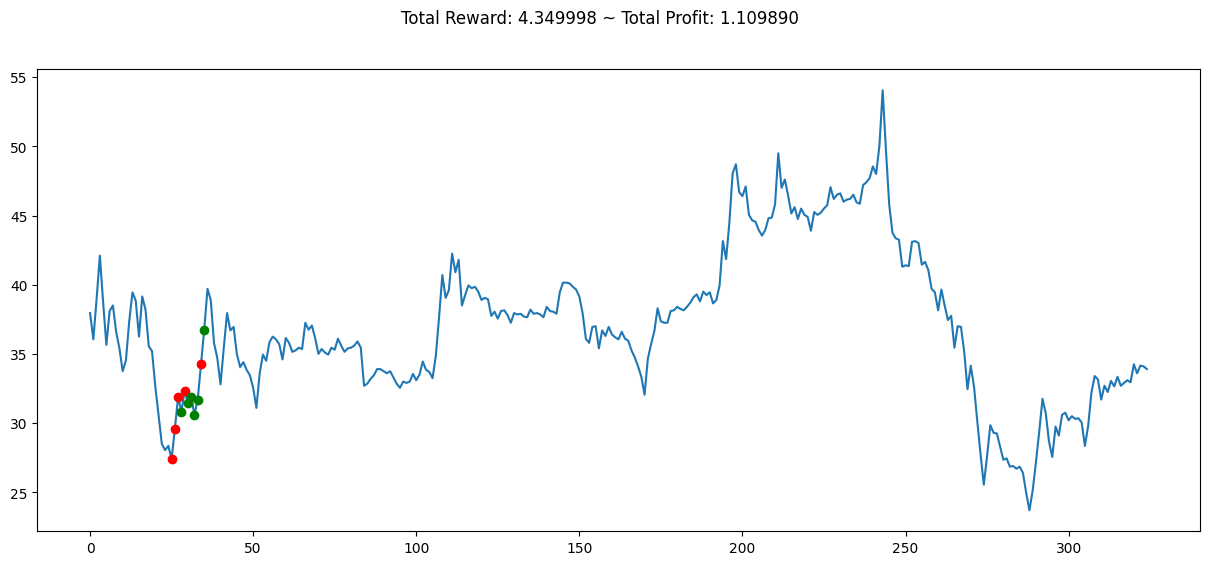

Maximum Reward Obtained was 8


In [185]:
# Create the initial model outside the loop
initial_df = pd.read_csv('./data_axis/batch (0).csv')
initial_df = pd.DataFrame(data=initial_df, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
env = StocksEnv(df=initial_df, window_size=25, frame_bound=(50, 350))
a2cModel = A2C("MlpPolicy", env)
a2cModel.save("a2c")
maxReward=-9999
for i in range(10):
    a2cModel = A2C.load("a2c", env=env)
    df = pd.read_csv('./data_axis/batch (%d).csv' % i)
    df = pd.DataFrame(data=df, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
    print(df.shape)
    env.df = df
    a2cModel.learn(total_timesteps=10)
    maxReward=max(maxReward,env._total_reward)
    a2cModel.save("a2c")
    # if total reward isn't exactly 1 (no buy / no sell)
    # if(env._total_profit != 1):
    #     
    print("Learning finished for batch (%d)" % i)
    del a2cModel
showProgress()
print("Maximum Reward Obtained was %d"%maxReward)

For a frame bound of 25 to 350 and a window size of 25, the model predicts buying or selling decisions based on the most recent 25 time steps, considering a historical context of the time steps. A positive prediction suggests a buying decision, while a negative prediction suggests selling. The approach balances short-term focus (window size) with a longer-term historical perspective (frame bound).
Here we see that the model gains a profit of 0.11 percent of the initial investment.


# Considering a Short term investor
The frame bound of a short term investor will be lesser and so will the window size. 
For a short-term investor with a frame bound of 100 and a window size of 10, the model emphasizes recent trends. It predicts buying or selling decisions based on the most recent 10 time steps, prioritizing short-term fluctuations. A positive prediction suggests a short-term buying decision, while a negative prediction suggests a short-term selling decision. The strategy focuses on capturing rapid market changes within a longer historical context.

(529, 5)
Learning finished for batch (0)
(531, 5)
Learning finished for batch (1)
(530, 5)
Learning finished for batch (2)
(530, 5)
Learning finished for batch (3)
(530, 5)
Learning finished for batch (4)
(530, 5)
Learning finished for batch (5)
(530, 5)
Learning finished for batch (6)
(530, 5)
Learning finished for batch (7)
(530, 5)
Learning finished for batch (8)
(530, 5)
Learning finished for batch (9)


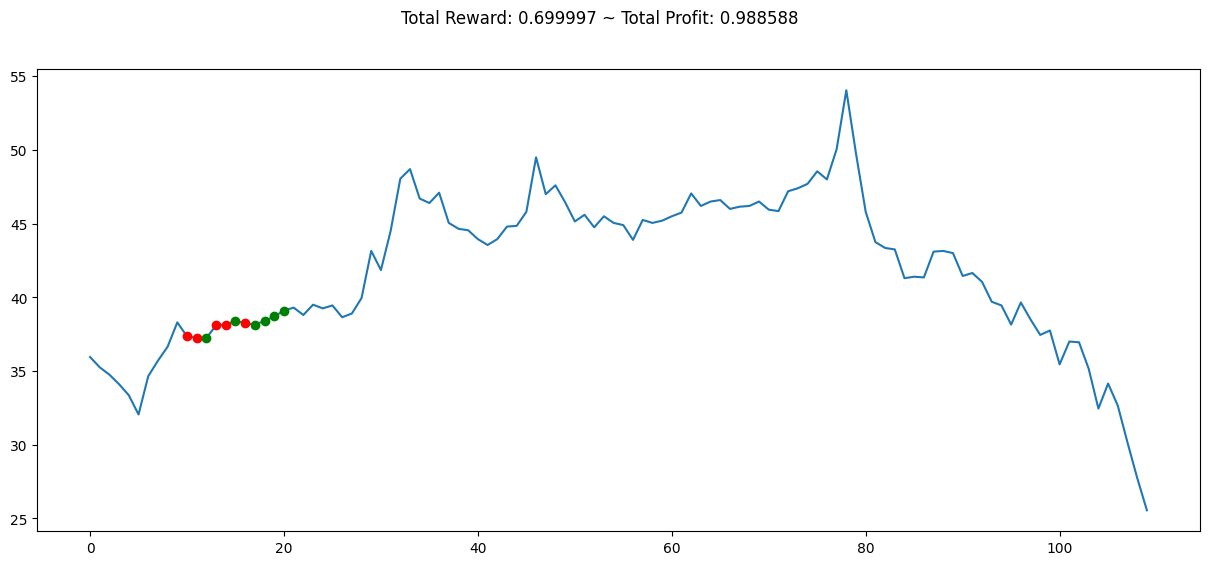

In [ ]:
# Create the initial model outside the loop
initial_df = pd.read_csv('./data_axis//batch (0).csv')
initial_df = pd.DataFrame(data=initial_df, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
env = StocksEnv(df=initial_df, window_size=10, frame_bound=(200, 300))
a2cShortModel = A2C("MlpPolicy", env)

for i in range(10):
    df = pd.read_csv('./data_axis/batch (%d).csv' % i)
    df = pd.DataFrame(data=df, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
    print(df.shape)
    env.df = df
    a2cShortModel.learn(total_timesteps=1000)
    print("Learning finished for batch (%d)" % i)
showProgress()

Here we see that the agent has traded in a very small amount of time and has gained a total loss of 0.12 percent. 

# The Difference

The difference between the agent and the actions in PPO algorithm can be based on the following factors:

## Volatility and Noise:
Short-Term (A2C): High-frequency trading in short-term investments is susceptible to market noise and volatility, impacting the agent's decision-making.
Long-Term (A2C): A2C exhibits more stable performance in the long term as it can adapt to slower-moving trends.
## Training Period:
Short-Term (A2C): A limited training period may result in the agent's inability to capture the complexity of changing market conditions.
Long-Term (A2C): Longer training periods in long-term investments allow A2C to learn and adapt to a broader range of market scenarios, improving overall performance.